# Imports

In [1]:
import os
from PIL import Image
import pandas as pd
import numpy as np
import shutil
import matplotlib.pyplot as plt
import csv
import pickle

# Input pipeline and preprocessing

## Dataset

In [2]:
# function for reading the images
# arguments: path to the traffic sign data, for example './GTSRB/Training'
# returns: list of images, list of corresponding labels 
def readTrafficSigns(rootpath):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns:   list of images, list of corresponding labels'''
    images = [] # images
    labels = [] # corresponding labels
    # loop over all 42 classes
    for c in range(0,43):
        prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
        gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        next(gtReader) # skip header
        # loop over all images in current annotations file
        for row in gtReader:
            images.append(plt.imread(prefix + row[0])) # the 1th column is the filename
            labels.append(row[7]) # the 8th column is the label
        gtFile.close()
    return images, labels

X_train, y_train = readTrafficSigns('./data/Training')

39209 39209


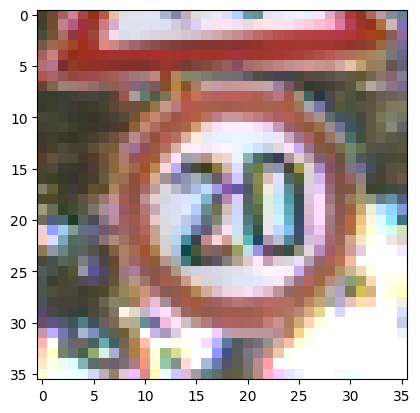

In [ ]:
print(len(X_train), len(y_train))
plt.imshow(X_train[42])
plt.show()

In [3]:
# Dictionaries erstellen
train = {'features': X_train, 'labels': y_train}
#valid = {'features': X_valid, 'labels': y_valid}
#test  = {'features': X_test,  'labels': y_test}

# Speichern
with open('./data/train.pkl', 'wb') as f:
    pickle.dump(train, f)
#with open('traffic-signs-data/valid.p', 'wb') as f:
#    pickle.dump(valid, f)
#with open('./data/test.p', 'wb') as f:
#    pickle.dump(test, f)

In [4]:
with open('./data/train.pkl', 'rb') as f:
    train = pickle.load(f)

print(train['features'][0].shape)
print(train['labels'][0])

(30, 29, 3)
0


# Training

In [ ]:
# ...

# Evaluation

In [ ]:
# ...